In [1]:
import pandas as pd
import glob

file_path = './Datasets/*.csv'
all_files = glob.glob(file_path)
df_list = []

for file in all_files:
    df = pd.read_csv(file) 
    df_list.append(df) 
# df pr

combined_df = pd.concat(df_list)
combined_df.sort_values(by='timestamp', inplace=True)
output_file = 'combined.csv'
combined_df.to_csv(output_file, index=False)

print(combined_df.head())

                   timestamp sensor      pm10      pm25  pm25_avg_15  \
0  2023-09-30 18:00:00+00:00    NaN  3.803667 -0.410000     0.994667   
0  2023-09-30 18:00:00+00:00    NaN  1.429000  5.957333     5.389000   
0  2023-09-30 18:00:00+00:00    NaN  0.281667  3.992000     3.621000   
0  2023-09-30 18:00:00+00:00    NaN  1.035000  5.494333     4.958667   
0  2023-09-30 18:00:00+00:00    NaN  1.080333  3.536333     3.338667   

   pm25_avg_60     pm100  
0    -0.007333  4.110667  
0     5.360667  2.837000  
0     4.186667  0.912667  
0     5.533333  1.485333  
0     3.211000  1.911667  


In [2]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7313994 entries, 0 to 0
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   timestamp    object 
 1   sensor       object 
 2   pm10         float64
 3   pm25         float64
 4   pm25_avg_15  float64
 5   pm25_avg_60  float64
 6   pm100        float64
dtypes: float64(5), object(2)
memory usage: 446.4+ MB


# install

In [3]:
!pip install gnnad

In [4]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from gnnad.graphanomaly import GNNAD
from gnnad.generate import GenerateGaussian, GenerateAnomaly
from gnnad.plot import plot_test_anomalies, plot_predictions, plot_sensor_error_scores

In [5]:
def normalise(X, scaler_fn):
    scaler = scaler_fn.fit(X)
    return pd.DataFrame(scaler.transform(X), index=X.index, columns = X.columns)

In [6]:
data_k = pd.read_csv('combined.csv')
data = data_k['pm25'] 
data

0          -0.410000
1           5.957333
2           3.992000
3           5.494333
4           3.536333
             ...    
7313989    20.570000
7313990    25.900000
7313991    25.660000
7313992     2.860000
7313993     2.660000
Name: pm25, Length: 7313994, dtype: float64

In [7]:
data = pd.read_csv('combined.csv')
data.drop(columns=['timestamp'], inplace=True)
data = pd.get_dummies(data, columns=['sensor'])
data['sensor_a'] = data['sensor_a'].astype(np.float64)
data['sensor_b'] = data['sensor_b'].astype(np.float64)
data

,pm10,pm25,pm25_avg_15,pm25_avg_60,pm100,sensor_a,sensor_b
0,3.803667,-0.410000,0.994667,-0.007333,4.110667,0.0,0.0
1,1.429000,5.957333,5.389000,5.360667,2.837000,0.0,0.0
2,0.281667,3.992000,3.621000,4.186667,0.912667,0.0,0.0
3,1.035000,5.494333,4.958667,5.533333,1.485333,0.0,0.0
4,1.080333,3.536333,3.338667,3.211000,1.911667,0.0,0.0
...,...,...,...,...,...,...,...
7313989,27.180000,20.570000,23.220000,21.100000,55.730000,0.0,1.0
7313990,31.070000,25.900000,28.940000,25.210000,61.380000,1.0,0.0
7313991,30.410000,25.660000,28.040000,24.280000,62.090000,0.0,1.0
7313992,4.170000,2.860000,3.120000,2.880000,4.840000,1.0,0.0


In [8]:
data['pm10'].unique()

array([ 3.80366667,  1.429     ,  0.28166667, ..., 29.53233333,
       21.644     , 31.42966667])

In [9]:
data['pm100'].unique()

array([ 4.11066667,  2.837     ,  0.91266667, ..., 34.87766667,
       54.86733333, 62.543     ])

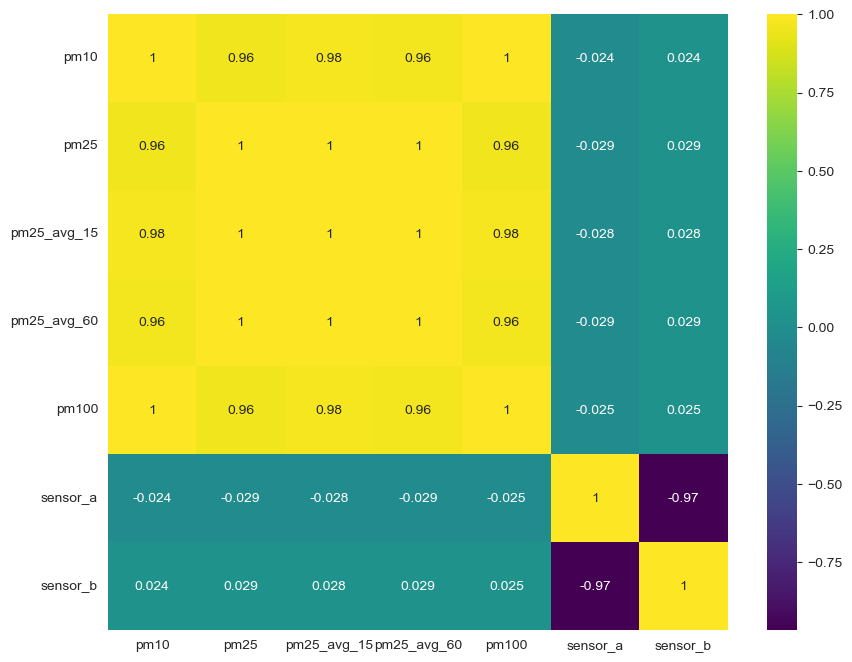

In [10]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='viridis')

plt.show()

In [11]:
# index'i integer tipine dönüştürme
data.index = data.index.astype('int64')

In [12]:
new_columns = pd.Int64Index(range(len(data.columns)))
data.columns = new_columns
data

/var/folders/vr/11d0bknx2ms1fxq4p99sr8tc0000gn/T/ipykernel_24150/3672452830.py:1: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  new_columns = pd.Int64Index(range(len(data.columns)))


,0,1,2,3,4,5,6
0,3.803667,-0.410000,0.994667,-0.007333,4.110667,0.0,0.0
1,1.429000,5.957333,5.389000,5.360667,2.837000,0.0,0.0
2,0.281667,3.992000,3.621000,4.186667,0.912667,0.0,0.0
3,1.035000,5.494333,4.958667,5.533333,1.485333,0.0,0.0
4,1.080333,3.536333,3.338667,3.211000,1.911667,0.0,0.0
...,...,...,...,...,...,...,...
7313989,27.180000,20.570000,23.220000,21.100000,55.730000,0.0,1.0
7313990,31.070000,25.900000,28.940000,25.210000,61.380000,1.0,0.0
7313991,30.410000,25.660000,28.040000,24.280000,62.090000,0.0,1.0
7313992,4.170000,2.860000,3.120000,2.880000,4.840000,1.0,0.0


In [13]:
# Kolonları sıfırdan itibaren numaralandırma
new_columns = list(range(len(data.columns)))
data.columns = new_columns

# DataFrame'i göster
data

,0,1,2,3,4,5,6
0,3.803667,-0.410000,0.994667,-0.007333,4.110667,0.0,0.0
1,1.429000,5.957333,5.389000,5.360667,2.837000,0.0,0.0
2,0.281667,3.992000,3.621000,4.186667,0.912667,0.0,0.0
3,1.035000,5.494333,4.958667,5.533333,1.485333,0.0,0.0
4,1.080333,3.536333,3.338667,3.211000,1.911667,0.0,0.0
...,...,...,...,...,...,...,...
7313989,27.180000,20.570000,23.220000,21.100000,55.730000,0.0,1.0
7313990,31.070000,25.900000,28.940000,25.210000,61.380000,1.0,0.0
7313991,30.410000,25.660000,28.040000,24.280000,62.090000,0.0,1.0
7313992,4.170000,2.860000,3.120000,2.880000,4.840000,1.0,0.0


In [14]:
data.index

RangeIndex(start=0, stop=7313994, step=1)

In [15]:
data.columns

Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64')

In [16]:
X_train, X_test = train_test_split(data, test_size=0.3, random_state=42)

In [17]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [18]:
anoms = GenerateAnomaly(X_test)

In [19]:
X_test = anoms.generate(anoms.variability)

In [20]:
X_test

,0,1,2,3,4,5,6
0,36.05,34.14,37.30,34.96,74.96,0.0,1.0
1,9.63,7.53,8.57,8.72,11.32,1.0,0.0
2,14.68,12.96,14.76,15.66,25.93,0.0,1.0
3,31.57,30.24,33.29,36.45,60.38,1.0,0.0
4,1.04,1.11,0.90,0.71,2.11,1.0,0.0
...,...,...,...,...,...,...,...
2194194,32.22,27.93,31.91,30.24,61.02,1.0,0.0
2194195,22.82,22.30,23.52,22.99,36.74,1.0,0.0
2194196,9.42,7.75,9.27,8.49,16.26,0.0,1.0
2194197,4.88,5.09,5.07,5.17,8.07,0.0,1.0


In [21]:
y_test = anoms.get_labels()

In [22]:
y_test

array([0, 0, 0, ..., 0, 0, 0])

In [23]:
value_counts = pd.Series(y_test).value_counts()

print(value_counts)

0    1997939
1     196260
dtype: int64


In [24]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_test, y_test = smote.fit_resample(X_test, y_test)

In [25]:
value_counts = pd.Series(y_test).value_counts()

print(value_counts)

0    1997939
1    1997939
dtype: int64


In [26]:
# normalise
X_test = normalise(X_test, preprocessing.StandardScaler())
X_train = normalise(X_train, preprocessing.StandardScaler())

In [27]:
# # create ANOOMS dict for plotting
# ANOMS = {'type1': {}}

# X_test_anoms = y_test.iloc[:,8:]

# for i in range(len(X_test_anoms.columns)):
#     anom_col_name = X_test_anoms.columns[i]
#     sensor_col_name = X_test.columns[i]
#     anom_idxs = X_test_anoms[anom_col_name][X_test_anoms[anom_col_name]].index

#     if len(anom_idxs) > 0:
#         ANOMS['type1'][sensor_col_name] = anom_idxs

In [28]:
# # plot input data
# plot_test_anomalies(X_test, ANOMS)

In [ ]:
# run model
model = GNNAD(threshold_type="max_validation",
              topk=6, 
              slide_win=300, 
              early_stop_win=200)
fitted_model = model.fit(X_train,
                         X_test,
                         y_test)

In [ ]:
# model summary
fitted_model.summary()

In [ ]:
# GDN+, sensor thresholds
preds = fitted_model.sensor_threshold_preds(tau = 99)
fitted_model.print_eval_metrics(preds)

In [ ]:
# plot predictions
# plot_predictions(fitted_model, X_test, ANOMS, preds = preds, figsize=(20, 20))